# Load Dataset

In [1]:
!cp /content/drive/MyDrive/PMCC/Dataset/mnMask.zip /content/
!unzip mnMask.zip

Archive:  mnMask.zip
   creating: mnMask/data/
   creating: mnMask/data/.ipynb_checkpoints/
   creating: mnMask/data/images/
   creating: mnMask/data/masks/
  inflating: mnMask/data/result.json  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-10.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-11.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-12.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-13.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-14.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-15.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-26.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_17h57m-22.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_17h57m-23.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_18h57m-19.png  
 extracting: m

In [24]:
!cp mnMask.zip /content/drive/MyDrive/PMCC/Dataset/

In [21]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
import numpy as np

image = read_image("mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_17h57m-11.png")
mask = np.load("mnMask/data/masks/10 Gy_GFP-H2B_A1_1_2023y06m24d_17h57m-11.npy")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask)

RuntimeError: [Errno 2] No such file or directory: 'mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_17h57m-11.png'

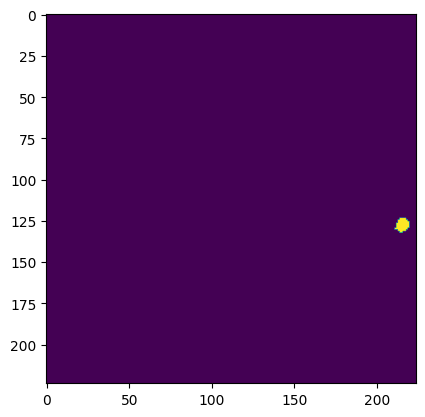

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

a3 = np.array( [[10,10],[100,10],[100,100],[10,100]], dtype=np.int32 )
im = np.zeros([240,320],dtype=np.uint8)
cv2.fillPoly( im, [a3], 255 )

def seperate_semantic_mask(mask):
  '''
  Convert mask that contains all obj into individual mask that
    contain each obj, from semantic seg to instance seg.

  Args:
    im: mask from the dataset

  Returns:
    [im]: list of masks
  '''

  # Convet the mask into binary
  binary_mask = (mask > 0).astype(np.uint8)

  # Find the connected components in the image
  num_labels, labels_im = cv2.connectedComponents(binary_mask)

  # Map component labels to individual masks
  individual_masks = []
  for label in range(1, num_labels):  # Start from 1 to skip the background
    individual_mask = (labels_im == label).astype(np.uint8)
    if individual_mask.sum() < 3: continue
    individual_masks.append(torch.from_numpy(individual_mask))

  # Return the list of individual masks
  return individual_masks

l = seperate_semantic_mask(mask)
binary_mask = (mask > 0).astype(np.uint8)
num_labels, labels_im = cv2.connectedComponents(binary_mask)
plt.imshow(l[1])

In [ ]:
torch.sum(l[1]>0)

tensor(1)

In [ ]:
masks_to_boxes(torch.stack(l))

tensor([[202., 118., 208., 124.],
        [210., 125., 210., 125.],
        [211., 124., 219., 132.],
        [209., 127., 209., 127.]])

In [14]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class mnMaskDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

    def __getitem__(self, idx):
        # load images and masks
        file_name = self.masks[idx].split(".")[0]
        mask_name = file_name + ".npy"
        img_name = file_name + ".png"
        # print(img_name)
        # print(mask_name)

        img_path = os.path.join(self.root, "images", img_name)
        mask_path = os.path.join(self.root, "masks", mask_name)
        img = read_image(img_path)
        mask = np.load(mask_path)

        # split the color-encoded mask into a set
        # of binary masks
        masks = seperate_semantic_mask(mask)
        if not masks: print(file_name)
        masks = torch.stack(masks)

        # instances are encoded as different colors
        # obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        # obj_ids = obj_ids[1:]
        num_objs = len(masks)
        # print(obj_ids)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)
        for box in boxes:
          if box[0] == box[2] or box[1] == box[3]:
            box[2] += 1
            box[3] += 1

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.masks)

In [22]:
ds = mnMaskDataset('mnMask/data')
print(len(ds))
for i in range(len(ds)):
    box = ds[i][1]['boxes']
    for b in box:
      if b[0] == b[2] and b[1] == b[3]:
        print(ds[i][2])
# list(sorted(os.listdir(os.path.join('data/data', "images"))))[48]

923


# Custom RCNN

### Finetune a pretrained model

In [25]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 198MB/s]


In [26]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 157MB/s]


In [27]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

def get_custom_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [28]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [29]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [31]:
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = mnMaskDataset('mnMask/data', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(0.2152, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0321, grad_fn=<DivBackward0>), 'loss_objectness': tensor(2.1924, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.1397, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [33]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = mnMaskDataset('mnMask/data', get_transform(train=True))
dataset_test = mnMaskDataset('mnMask/data', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [  0/437]  eta: 0:00:43  lr: 0.000016  loss: 3.3690 (3.3690)  loss_classifier: 0.6793 (0.6793)  loss_box_reg: 0.0088 (0.0088)  loss_mask: 0.9509 (0.9509)  loss_objectness: 1.6500 (1.6500)  loss_rpn_box_reg: 0.0800 (0.0800)  time: 0.0995  data: 0.0081  max mem: 2577
Epoch: [0]  [ 10/437]  eta: 0:00:36  lr: 0.000131  loss: 2.4155 (2.6385)  loss_classifier: 0.5574 (0.5170)  loss_box_reg: 0.0317 (0.0395)  loss_mask: 0.9291 (0.9436)  loss_objectness: 0.7374 (1.0489)  loss_rpn_box_reg: 0.0430 (0.0895)  time: 0.0858  data: 0.0077  max mem: 2747
Epoch: [0]  [ 20/437]  eta: 0:00:35  lr: 0.000246  loss: 1.2740 (1.7884)  loss_classifier: 0.2394 (0.3405)  loss_box_reg: 0.0317 (0.0434)  loss_mask: 0.5580 (0.7199)  loss_objectness: 0.1823 (0.6121)  loss_rpn_box_reg: 0.0293 (0.0725)  time: 0.0836  data: 0.0077  max mem: 2765
Epoch: [0]  [ 30/437]  eta: 0:00:34  lr: 0.000360  loss: 0.6605 (1.4144)  loss_classifier: 0.0797 (0.2509)  loss_box_reg: 0.0324 (0.0433)  loss_mask: 0.3936 (0.6122) 

Tested with customized backbone

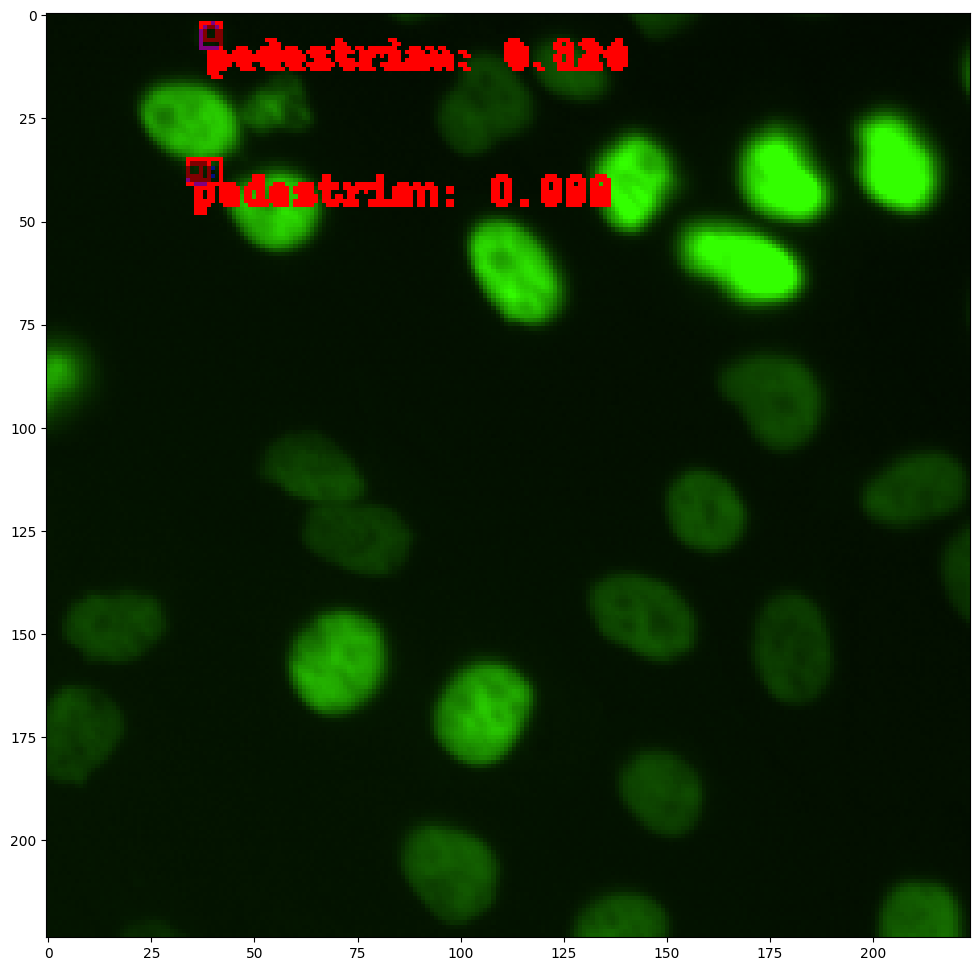

In [35]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-26.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

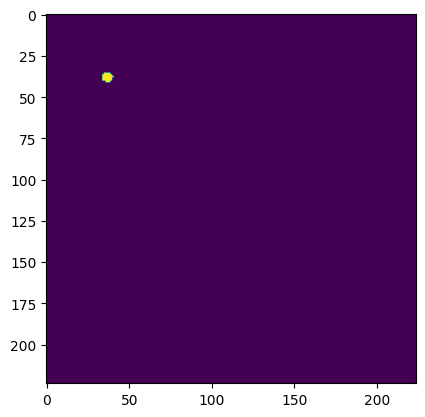

In [51]:
plt.imshow(masks.cpu()[4])

In [36]:
torch.save(model.state_dict(), 'RCNN.pt')

In [37]:
!cp RCNN.pt drive/MyDrive/PMCC/models

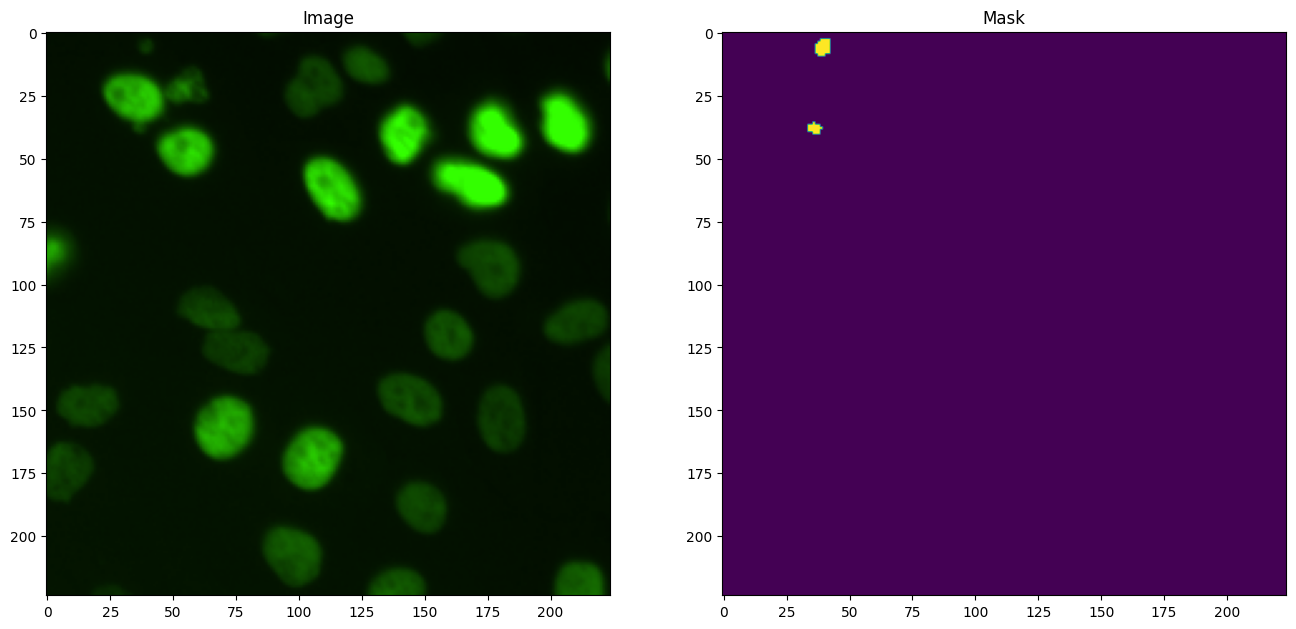

In [ ]:
image = read_image("data/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-26.png")
mask = np.load("data/data/masks/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-26.npy")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask)